In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import rasterio
from rasterio.plot import show
import xarray as xr
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats


In [3]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Load the grid
grid = gpd.read_file('catalonia_traffic_grid_25m.geojson')


In [4]:

# Path to the EuroDEM elevation data
elevation_path = '../eurodem/eurodem.tif'


In [5]:
print(grid.crs)  # Check CRS of the grid
with rasterio.open(elevation_path) as src:
    raster_crs = src.crs

EPSG:25831


In [6]:
grid = grid.to_crs(raster_crs)

In [8]:
grid[:100].shape

(100, 3)

In [16]:


# Compute zonal statistics (mean elevation for each grid cell)
elevation_stats = zonal_stats(
    grid,  # The GeoDataFrame containing the grid
    elevation_path,  # The raster file path
    stats="mean",  # Compute the mean elevation for each grid cell
    geojson_out=True,  # Output GeoJSON format to keep properties intact
    all_touched=True
)

# Convert the zonal stats result back to a GeoDataFrame
# This step ensures the elevation data is added to your grid
updated_grid = gpd.GeoDataFrame.from_features(elevation_stats)

# Rename the elevation column for clarity
updated_grid.rename(columns={"mean": "elevation_mean"}, inplace=True)

# Save the updated grid with elevation information
updated_grid.to_file("catalonia_traffic_grid_with_elevation.geojson", driver="GeoJSON")

print("Elevation data added and saved to 'catalonia_traffic_grid_with_elevation.geojson'")

Elevation data added and saved to 'catalonia_traffic_grid_with_elevation.geojson'


In [24]:
print("hola")

hola


In [23]:
updated_grid.to_file("catalonia_traffic_grid_with_elevation.geojson", driver="GeoJSON")

In [ ]:
updated_grid

In [18]:
updated_grid['elevation_mean'].isna().sum()

24197

In [4]:
updated_grid = gpd.read_file('catalonia_traffic_grid_with_elevation.geojson')


In [6]:
updated_grid.columns

Index(['index', 'mean_imd_tot', 'elevation_mean', 'geometry'], dtype='object')

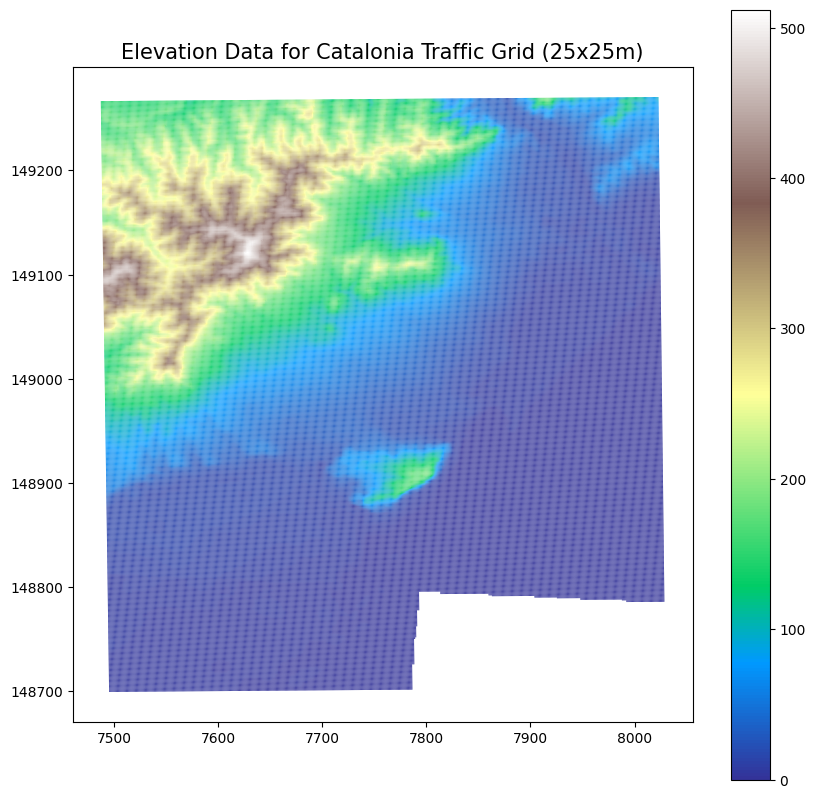

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
updated_grid.plot(column='elevation_mean', cmap='terrain', legend=True, ax=ax)
ax.set_title('Elevation Data for Catalonia Traffic Grid (25x25m)', fontsize=15)
plt.show()

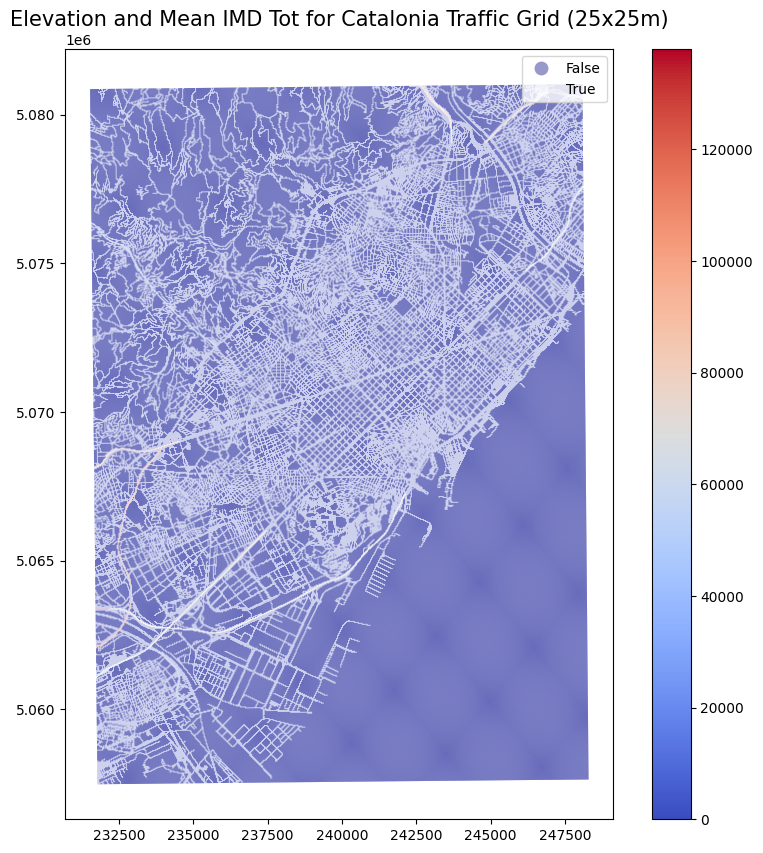

In [ ]:
import matplotlib.pyplot as plt

# Create a figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the mean_imd_tot as the first layer with some transparency
updated_grid.plot(column='mean_imd_tot', cmap='coolwarm', legend=True, ax=ax, alpha=0.5)

# Plot the elevation_mean on top of mean_imd_tot with some transparency
updated_grid.plot(column='elevation_mean', cmap='terrain', legend=True, ax=ax, alpha=0.5)

# Set the title
ax.set_title('Elevation and Mean IMD Tot for Catalonia Traffic Grid (25x25m)', fontsize=15)

# Show the plot
plt.show()


In [5]:
roads_grid = gpd.read_file('catalonia_grid_with_roads.geojson')

In [6]:
roads_grid['elevation_mean'] = updated_grid['elevation_mean']

In [15]:
roads_grid.columns

Index(['index', 'mean_imd_tot', 'has_road', 'geometry', 'elevation_mean'], dtype='object')

In [440]:
import pyreadr
urban = pyreadr.read_r('../CALIOPE-Urban/UK_20230101.rds')
df = urban[None]  # Assuming you're selecting the DataFrame from the RDS object

df['date'] = pd.to_datetime(df['date'])

# Select the data for a single time point (e.g., the first date in the dataset)
df_selected = df[df['date'] == df['date'].unique()[1]] 

# Convert it to a GeoDataFrame
gdf_urban = gpd.GeoDataFrame(df_selected, 
                             geometry=gpd.points_from_xy(df_selected.X, df_selected.Y),
                             crs="EPSG:32631")  # Assuming the coordinates are in EPSG:32631

In [441]:
gdf_urban

,date,pollutant_uk,var_uk,X,Y,rec_id,geometry
rownames,,,,,,,
52018,2023-01-01 01:00:00,46.970237,156.640914,423697.869000,4.581609e+06,1.0,POINT (423697.869 4581609.274)
52019,2023-01-01 01:00:00,131.482102,4616.618860,430209.641000,4.582376e+06,2.0,POINT (430209.641 4582376.342)
52020,2023-01-01 01:00:00,63.607150,397.125102,426559.886000,4.582073e+06,3.0,POINT (426559.886 4582073.149)
52021,2023-01-01 01:00:00,47.413267,155.902307,428806.907000,4.583809e+06,4.0,POINT (428806.907 4583808.904)
52022,2023-01-01 01:00:00,39.000000,0.000000,433524.063000,4.583962e+06,5.0,POINT (433524.063 4583962.143)
...,...,...,...,...,...,...,...
104031,2023-01-01 01:00:00,36.419452,87.895494,423866.620000,4.590393e+06,52401.0,POINT (423866.620 4590393.219)
104032,2023-01-01 01:00:00,33.603189,78.619847,426791.620000,4.590393e+06,52402.0,POINT (426791.620 4590393.219)
104033,2023-01-01 01:00:00,33.593315,78.607009,426816.620000,4.590393e+06,52403.0,POINT (426816.620 4590393.219)


In [414]:
if roads_grid.crs != gdf_urban.crs:
    roads_grid = roads_grid.to_crs(gdf_urban.crs)

# Step 3: Perform the spatial join to combine the data based on location
# The join will attach columns from 'roads_grid' to the points in 'gdf_urban' that fall within the grid cells
gdf_joined = gpd.sjoin(gdf_urban, roads_grid, how="right", op='within')

# Step 4: Inspect the result
print(gdf_joined.head())

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


  index_left date  pollutant_uk  var_uk   X   Y  rec_id  index  mean_imd_tot  \
0        NaN  NaT           NaN     NaN NaN NaN     NaN      0           0.0   
1        NaN  NaT           NaN     NaN NaN NaN     NaN      1           0.0   
2        NaN  NaT           NaN     NaN NaN NaN     NaN      2           0.0   
3        NaN  NaT           NaN     NaN NaN NaN     NaN      3           0.0   
4        NaN  NaT           NaN     NaN NaN NaN     NaN      4           0.0   

   has_road                                           geometry  elevation_mean  
0      True  POLYGON ((423154.120 4573055.719, 423179.120 4...             2.0  
1      True  POLYGON ((423154.120 4573080.719, 423179.120 4...             2.0  
2      True  POLYGON ((423154.120 4573105.719, 423179.120 4...             2.0  
3      True  POLYGON ((423154.120 4573130.719, 423179.120 4...             2.0  
4      True  POLYGON ((423154.120 4573155.719, 423179.120 4...             2.0  


C:\Users\Usuario\AppData\Local\Temp\ipykernel_18564\1887053594.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


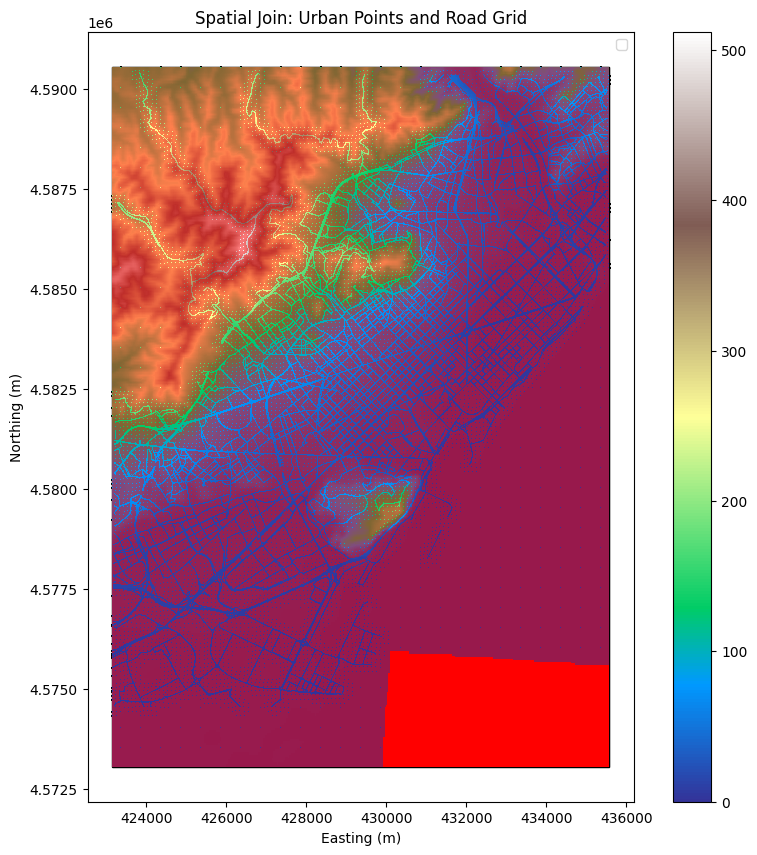

In [89]:
import matplotlib.pyplot as plt

# Step 5: Plot the results to verify if the join is correct
# Plot roads_grid (grid) and the urban points from gdf_joined

# Plot the grid (roads_grid) first
ax = gdf_joined.plot(facecolor='lightgrey', edgecolor='black', figsize=(10, 10))

# Then plot the urban points (from gdf_joined) on top
gdf_joined.plot(ax=ax, color='red', markersize=10, label="pollutant_uk")

# Plot the elevation_mean on top of mean_imd_tot with some transparency
gdf_joined.plot(column='elevation_mean', cmap='terrain', legend=True, ax=ax, alpha=0.5)

# Set the title
ax.set_title('Elevation and Mean IMD Tot for Catalonia Traffic Grid (25x25m)', fontsize=15)

# Show the plot


# Add a legend and labels
plt.legend()
plt.title('Spatial Join: Urban Points and Road Grid')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

# Show the plot
plt.show()


In [418]:
df = gdf_joined.copy()

In [419]:
df['pollutant_uk'] = pd.to_numeric(df['pollutant_uk'], errors='coerce')

In [420]:
df = df.reset_index(drop=True)


In [421]:
df['pollutant_uk'] = df['pollutant_uk'].interpolate(method='linear')

In [422]:
df['elevation_mean'] = df['elevation_mean'].fillna(0)

In [423]:
df.isna().sum()

index_left        296312
date              296312
pollutant_uk          51
var_uk            296313
X                 296312
Y                 296312
rec_id            296312
index                  0
mean_imd_tot           0
has_road               0
geometry               0
elevation_mean         0
dtype: int64

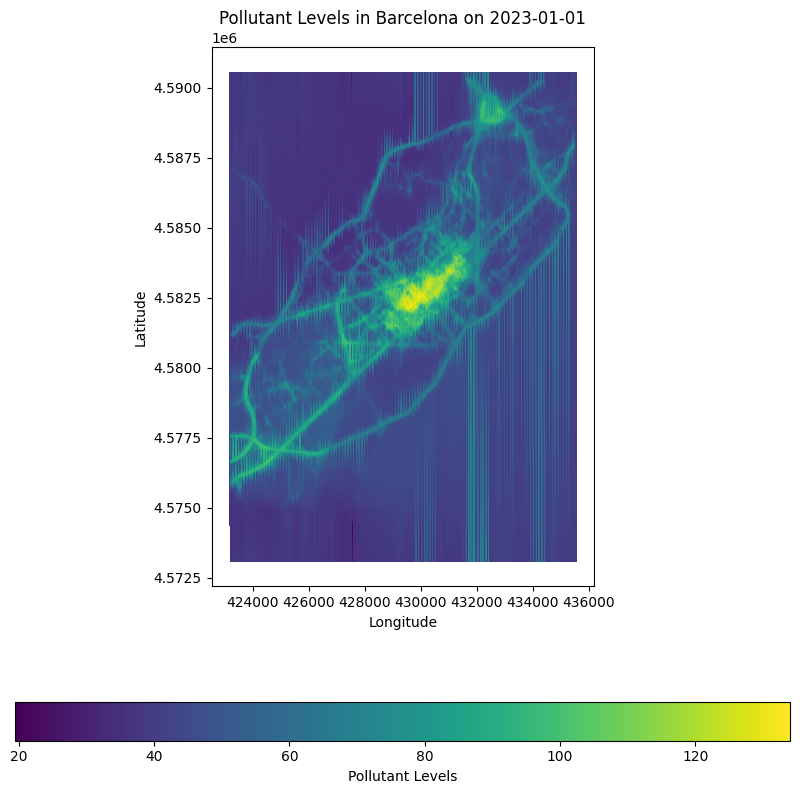

In [59]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 10))

# Normalize pollutant data for color mapping
norm = mpl.colors.Normalize(vmin=df['pollutant_uk'].min(), vmax=df['pollutant_uk'].max())

# Plot the data with a colormap
df.plot(ax=ax, 
         marker='o', 
         column='pollutant_uk', 
         cmap='viridis', 
         markersize=5, 
         legend=True, 
         legend_kwds={'label': "Pollutant Levels",
                      'orientation': "horizontal"})

# Add title and labels
ax.set_title('Pollutant Levels in Barcelona on 2023-01-01')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()



In [424]:
df = df.to_crs(crs="EPSG:32631")

In [229]:
df['centroid'] = df['geometry'].centroid

In [230]:
df['lon'] = df['centroid'].x
df['lat'] = df['centroid'].y

In [280]:
# 4. Load NO2 data (NetCDF format)
no2_data = xr.open_dataset('../NO2/sconcno2_2023010100.nc', engine='netcdf4')

In [281]:
first_time = no2_data.isel(time=10)

In [282]:

no2df = first_time[["sconcno2", "lat", "lon"]].to_dataframe().reset_index()

In [284]:
import pandas as pd
import numpy as np

# Calculate the grid index for each point based on lat and lon
def get_grid_index(lat, lon, grid_size=1000):
    # Assuming grid_size = 1000 meters (1 km)
    lat_idx = int(lat // (grid_size / 1000))
    lon_idx = int(lon // (grid_size / 1000))
    return lat_idx, lon_idx

no2df['grid_lat_idx'], no2df['grid_lon_idx'] = zip(*no2df.apply(lambda row: get_grid_index(row['lat'], row['lon']), axis=1))

# Aggregate `sconcno2` within each 3x3 km grid
grid_sconc = no2df.groupby(['grid_lat_idx', 'grid_lon_idx'])['sconcno2'].mean().reset_index()


In [286]:
gdf = df.copy()

In [401]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
import numpy as np

import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box
import pandas as pd

def extract_spatial_regions(no2_df, uk_gdf, grid_size_m=3000, sub_resolution_m=25):
    """
    Extract 3km x 3km regions with 25m resolution features efficiently.

    Parameters:
    -----------
    no2_df : pandas.DataFrame
        Input NO2 concentration dataframe
    uk_gdf : geopandas.GeoDataFrame
        Input UK pollution and contextual data
    grid_size_m : int, optional
        Size of grid regions in meters (default 3000m = 3km)
    sub_resolution_m : int, optional
        Resolution of sub-grids (default 25m)

    Returns:
    --------
    list : List of dictionaries, each representing a 3km x 3km region
    """

    # 1. Efficient CRS Handling and GeoDataFrame Creation:
    if not isinstance(no2_df, gpd.GeoDataFrame):
      no2_gdf = gpd.GeoDataFrame(
          no2_df,
          geometry=gpd.points_from_xy(no2_df['lon'], no2_df['lat']),
          crs='EPSG:4326'
      )
    else:
      no2_gdf = no2_df

    # Ensure consistent CRS upfront to avoid repeated transformations
    if no2_gdf.crs != uk_gdf.crs:
        no2_gdf = no2_gdf.to_crs(uk_gdf.crs)

    # 2. Spatial Indexing for Faster Spatial Operations:
    uk_gdf.sindex  # Build spatial index for uk_gdf (if not already built)
    no2_gdf.sindex

    # 3. Optimized Grid Creation and Iteration:
    min_x, min_y, max_x, max_y = no2_gdf.total_bounds
    
    # Pre-compute grid coordinates
    grid_xs = np.arange(min_x, max_x + grid_size_m, grid_size_m)
    grid_ys = np.arange(min_y, max_y + grid_size_m, grid_size_m)
    
    # Pre-compute 25m cell coordinates
    cell_xs = np.arange(0, grid_size_m, sub_resolution_m)
    cell_ys = np.arange(0, grid_size_m, sub_resolution_m)

    regions = []

    # 4. Vectorized Operations within Grid Cells:
    for grid_x in grid_xs:
        for grid_y in grid_ys:
            grid_bbox = box(grid_x, grid_y, grid_x + grid_size_m, grid_y + grid_size_m)

            # Efficiently filter using spatial index
            possible_uk_matches_index = list(uk_gdf.sindex.intersection(grid_bbox.bounds))
            possible_uk_matches = uk_gdf.iloc[possible_uk_matches_index]
            uk_subset = possible_uk_matches[possible_uk_matches.intersects(grid_bbox)]

            possible_no2_matches_index = list(no2_gdf.sindex.intersection(grid_bbox.bounds))
            possible_no2_matches = no2_gdf.iloc[possible_no2_matches_index]
            no2_subset = possible_no2_matches[possible_no2_matches.intersects(grid_bbox)]

            if not no2_subset.empty and not uk_subset.empty:
                # Initialize feature arrays

                max_no2 = no2_subset['sconcno2'].max()
                features = {
                    'has_road': np.zeros((120, 120), dtype=np.int8),
                    'elevation': np.zeros((120, 120)),
                    'imd_total': np.zeros((120, 120)),
                    'no2_conc': np.full((120, 120), max_no2),
                    'pollutant_uk': np.zeros((120, 120)),
                }

                # Vectorized creation of cell geometries
                cell_boxes = [
                    box(grid_x + cell_x, grid_y + cell_y, grid_x + cell_x + sub_resolution_m, grid_y + cell_y + sub_resolution_m)
                    for cell_y in cell_ys
                    for cell_x in cell_xs
                ]
                cell_boxes = gpd.GeoSeries(cell_boxes, crs=uk_gdf.crs)

                # Use spatial join for faster association
                uk_cell_matches = gpd.sjoin(cell_boxes.to_frame('geometry'), uk_subset, how='left', predicate='intersects')
                no2_cell_matches = gpd.sjoin(cell_boxes.to_frame('geometry'), no2_subset, how='left', predicate='intersects')

                # Vectorized feature assignment using numpy indexing
                uk_cell_matches_grouped = uk_cell_matches.groupby(uk_cell_matches.index)

                # Assign values only if group exists
                if not uk_cell_matches.empty:
                    for index, group in uk_cell_matches_grouped:
                        i, j = divmod(index, 120)  # Reverse engineer i, j from flattened index
                        features['has_road'][i, j] = group['has_road'].iloc[0] if not np.isnan(group['has_road'].iloc[0]) else 0
                        features['elevation'][i, j] = group['elevation_mean'].iloc[0] if not np.isnan(group['elevation_mean'].iloc[0]) else 0
                        features['imd_total'][i, j] = group['mean_imd_tot'].iloc[0] if not np.isnan(group['mean_imd_tot'].iloc[0]) else 0
                        features['pollutant_uk'][i,j] = group['pollutant_uk'].iloc[0] if not np.isnan(group['pollutant_uk'].iloc[0]) else 0

                regions.append({
                    'bbox_x': grid_x,
                    'bbox_y': grid_y,
                    'features': features
                })

    return regions

# Example usage (commented out)
regions = extract_spatial_regions(no2df, gdf)
print(len(regions))  # Number of regions
print(regions[0]['features'].keys())  # Feature types

35
dict_keys(['has_road', 'elevation', 'imd_total', 'no2_conc', 'pollutant_uk'])


In [410]:
print(regions[20]['features']['no2_conc'])

[[0.02485342 0.02485342 0.02485342 ... 0.02485342 0.02485342 0.02485342]
 [0.02485342 0.02485342 0.02485342 ... 0.02485342 0.02485342 0.02485342]
 [0.02485342 0.02485342 0.02485342 ... 0.02485342 0.02485342 0.02485342]
 ...
 [0.02485342 0.02485342 0.02485342 ... 0.02485342 0.02485342 0.02485342]
 [0.02485342 0.02485342 0.02485342 ... 0.02485342 0.02485342 0.02485342]
 [0.02485342 0.02485342 0.02485342 ... 0.02485342 0.02485342 0.02485342]]


In [342]:
no2_gdf = gpd.GeoDataFrame(
        no2df,
    geometry=gpd.points_from_xy(no2df['lon'], no2df['lat']),
    crs='EPSG:32631'
)

In [343]:
no2_gdf

,lev,y,x,sconcno2,lat,lon,time,grid_lat_idx,grid_lon_idx,geometry
0,0.0,44361.289817,253651.886803,0.000579,40.361107,-0.001190,2023-01-01 10:00:00,40,-1,POINT (-0.001 40.361)
1,0.0,44361.289817,254651.602550,0.000588,40.360806,0.010620,2023-01-01 10:00:00,40,0,POINT (0.011 40.361)
2,0.0,44361.289817,255651.293957,0.000678,40.360512,0.022430,2023-01-01 10:00:00,40,0,POINT (0.022 40.361)
3,0.0,44361.289817,256651.018356,0.000612,40.360210,0.034241,2023-01-01 10:00:00,40,0,POINT (0.034 40.360)
4,0.0,44361.289817,257650.805019,0.000562,40.359894,0.046051,2023-01-01 10:00:00,40,0,POINT (0.046 40.360)
...,...,...,...,...,...,...,...,...,...,...
82839,0.0,341362.061749,526651.812460,0.001322,42.901028,3.472961,2023-01-01 10:00:00,42,3,POINT (3.473 42.901)
82840,0.0,341362.061749,527652.638687,0.001363,42.900372,3.485199,2023-01-01 10:00:00,42,3,POINT (3.485 42.900)
82841,0.0,341362.061749,528651.041814,0.001383,42.899719,3.497437,2023-01-01 10:00:00,42,3,POINT (3.497 42.900)
82842,0.0,341362.061749,529651.886276,0.001391,42.899063,3.509705,2023-01-01 10:00:00,42,3,POINT (3.510 42.899)


In [ ]:
import json
with open("prova.json", 'w') as f:
    json.dump(regions, f)
regions

[{'bbox_x': 422154.85482332576,
  'bbox_y': 4570478.899278682,
  'features': {'has_road': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 1, 0, 0]], dtype=int8),
   'elevation': array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 2., 2., 2.],
          [0., 0., 0., ..., 2., 2., 2.],
          [0., 0., 0., ..., 2., 2., 2.]]),
   'imd_total': array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]),
   'no2_conc': array([[0.03145974, 0.03145974, 0.03145974, ..., 0.03145974, 0.03145974,
           0.03145974],
          

In [231]:
import xarray as xr
import geopandas as gpd
import pandas as pd

def xarray_to_geodataframe(no2_data: xr.Dataset) -> gpd.GeoDataFrame:

    # 1. Convert relevant data variables to a Pandas DataFrame
    df = no2_data[["sconcno2", "lat", "lon"]].to_dataframe().reset_index()

    # 2. Create Point geometries from lat/lon
    geometry = gpd.points_from_xy(df.lon, df.lat)

    # 3. Create the GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  # Assuming WGS 84

    return gdf

gdfno2 = xarray_to_geodataframe(no2_data)


In [233]:
gdfno2.shape

(3976512, 8)

In [235]:
 df['centroid'] = df.geometry.centroid
 df = df.set_geometry('centroid')

In [241]:
gdfno2 = gdfno2.to_crs("EPSG:32631")

In [242]:
joined_points = gpd.sjoin(gdfno2, df[['centroid', 'geometry']], how="left", predicate="within")

In [ ]:
 merged_data = df.merge(joined_points[['grid_id', 'sconcno2']], on='grid_id', how='left')

In [234]:
gdfno2_buffered = gdfno2.copy()
gdfno2_buffered['geometry'] = gdfno2_buffered.geometry.buffer(500)  # Buffer by 500 meters (half of 1km)

# Step 2: Perform the spatial join between the buffered points and `df`
# Now we will join the `gdfno2` grid (which has been buffered) with `df` to ensure each point inside the grid gets the correct value
gdf_joined = gpd.sjoin(gdfno2_buffered, df, how="right", op='intersects')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18508\1680629416.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdfno2_buffered['geometry'] = gdfno2_buffered.geometry.buffer(500)  # Buffer by 500 meters (half of 1km)


KeyboardInterrupt: 

In [228]:
gdf_joined.shape

(17481179, 22)

In [211]:
gdf_joined['sconcno2'] = gdf_joined['sconcno2'].interpolate(method='nearest')

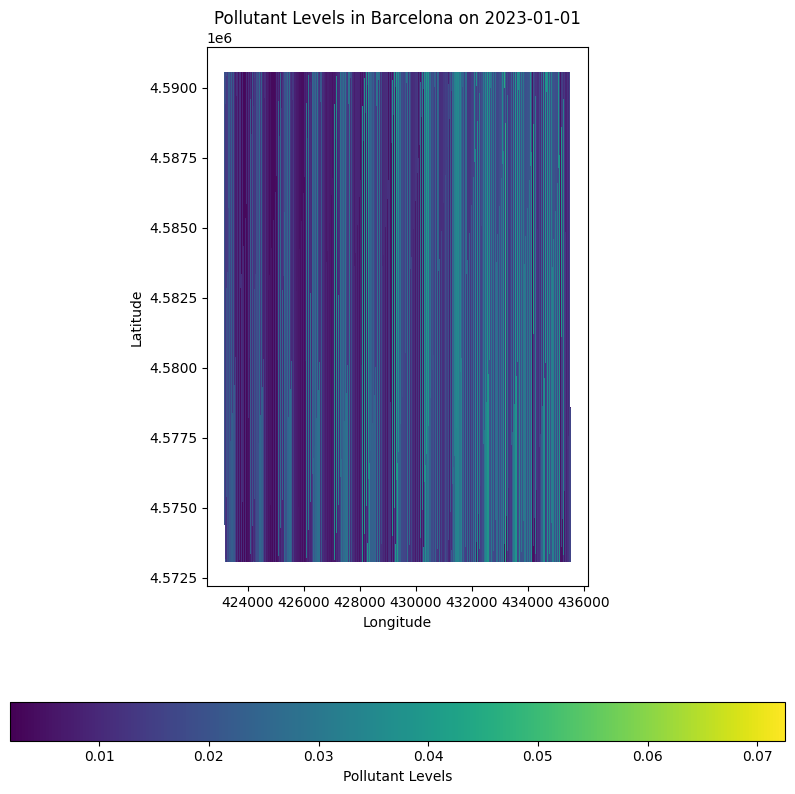

In [212]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 10))

# Normalize pollutant data for color mapping
norm = mpl.colors.Normalize(vmin=gdf_joined['sconcno2'].min(), vmax=gdf_joined['sconcno2'].max())

# Plot the data with a colormap
gdf_joined.plot(ax=ax, 
         marker='o', 
         column='sconcno2', 
         cmap='viridis', 
         markersize=5, 
         legend=True, 
         legend_kwds={'label': "Pollutant Levels",
                      'orientation': "horizontal"})

# Add title and labels
ax.set_title('Pollutant Levels in Barcelona on 2023-01-01')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()



Kriging didn't work well and was too slow

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 9.474909909885695e-25
Nugget: 314.58815070863244 



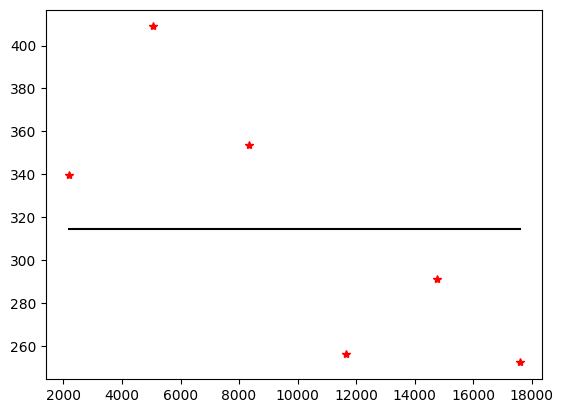

Calculating statistics on variogram model fit...


In [121]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt

# Step 1: Extract the coordinates and pollutant data from gdf_joined
# Filter rows where 'pollutant_uk' is not NaN for training Kriging model
gdf_interpolation = gdf_joined[gdf_joined['pollutant_uk'].notna()]

# Randomly sample a subset of the data (e.g., 1000 points)
sample_size = 1000
gdf_sample = gdf_interpolation.sample(n=sample_size, random_state=42)

# Extract coordinates and pollutant values from the sampled data
X_train = gdf_sample['X']  # X coordinates
Y_train = gdf_sample['Y'].values  # Y coordinates
Z_train = gdf_sample['pollutant_uk'].values  # pollutant_uk values

# Step 2: Set up the Kriging model (Ordinary Kriging)
OK = OrdinaryKriging(X_train, Y_train, Z_train, variogram_model='spherical', verbose=True, enable_plotting=True)

In [128]:
gdf_joined.isna().sum()

index_left        296312
date              296312
pollutant_uk      296313
var_uk            296313
X                 296312
Y                 296312
rec_id            296312
index                  0
mean_imd_tot           0
has_road               0
geometry               0
elevation_mean     24197
dtype: int64

In [129]:

# Step 3: Extract the coordinates of missing values (NaN in 'pollutant_uk')
gdf_missing = gdf_joined[gdf_joined['pollutant_uk'].isna()]
X_missing = gdf_missing['X'].values  # X coordinates of missing points
Y_missing = gdf_missing['Y'].values  # Y coordinates of missing points

# Step 4: Predict the missing values using the Kriging model
Z_pred, ss = OK.execute('points', X_missing, Y_missing)  # 'points' will predict for the provided coordinates

# Step 5: Assign the predicted values back into the GeoDataFrame
gdf_joined.loc[gdf_joined['pollutant_uk'].isna(), 'pollutant_uk'] = Z_pred

# Step 6: Plot the result to verify interpolation
# Plot the grid (roads_grid) and the interpolated pollutant_uk values



Executing Ordinary Kriging...



MemoryError: Unable to allocate 22.1 GiB for an array with shape (296313, 10000) and data type float64

In [101]:
gdf_joined.isna().sum()

index_left        296312
date              296312
pollutant_uk           0
var_uk            409055
X                 296312
Y                 296312
rec_id            296312
index                  0
mean_imd_tot           0
has_road               0
geometry               0
elevation_mean     25462
dtype: int64

In [77]:
nona = gdf_joined.copy()

In [79]:
nona = nona.dropna()

In [84]:
gdf_joined.isna().sum()

date                   0
pollutant_uk      112931
var_uk            112931
X                      0
Y                      0
rec_id                 0
geometry               0
index_right         1896
index               1896
mean_imd_tot        1896
has_road            1896
elevation_mean      3216
dtype: int64

In [107]:
gdf_joined.shape

(1552136, 12)

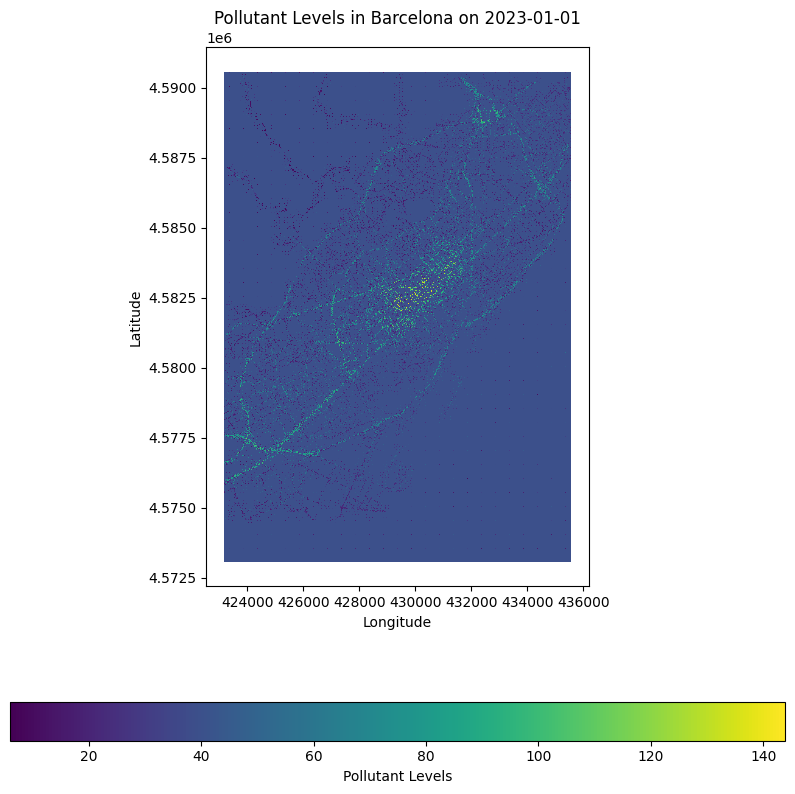

In [110]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 10))

# Normalize pollutant data for color mapping
norm = mpl.colors.Normalize(vmin=gdf_joined['pollutant_uk'].min(), vmax=gdf_joined['pollutant_uk'].max())

# Plot the data with a colormap
gdf_joined.plot(ax=ax, 
         marker='o', 
         column='pollutant_uk', 
         cmap='viridis', 
         markersize=5, 
         legend=True, 
         legend_kwds={'label': "Pollutant Levels",
                      'orientation': "horizontal"})

# Add title and labels
ax.set_title('Pollutant Levels in Barcelona on 2023-01-01')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()



In [ ]:
gdf_merged.isna().sum()

date                   0
pollutant_uk      112743
var_uk            112743
X                      0
Y                      0
rec_id                 0
geometry               0
index_right            0
index                  0
mean_imd_tot           0
has_road               0
elevation_mean      1320
dtype: int64

In [29]:
import folium
from folium import Choropleth
import geopandas as gpd

# Load the updated grid with elevation data
updated_grid = gpd.read_file("catalonia_traffic_grid_with_elevation.geojson")

# Reproject to WGS84 for compatibility with folium (latitude/longitude)
updated_grid = updated_grid.to_crs(epsg=4326)

# Create a folium map centered on the grid's centroid
map_center = updated_grid.geometry.centroid.unary_union.centroid
m = folium.Map(
    location=[map_center.y, map_center.x], 
    zoom_start=10, 
    tiles="Stamen Terrain", 
    attr="Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL."
)

# Add elevation data as a choropleth layer
Choropleth(
    geo_data=updated_grid,
    data=updated_grid,
    columns=["index", "elevation_mean"],  # Assuming 'id' uniquely identifies each grid cell
    key_on="feature.properties.index",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Mean Elevation (m)"


    
).add_to(m)

# Add a tooltip to display elevation information
folium.GeoJson(
    updated_grid,
    tooltip=folium.GeoJsonTooltip(fields=["elevation_mean"], aliases=["Elevation (m):"])
).add_to(m)

# Display the map
m.save("catalonia_traffic_elevation_map.html")
print("Interactive map saved to 'catalonia_traffic_elevation_map.html'")


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10312\3343723097.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = updated_grid.geometry.centroid.unary_union.centroid


Interactive map saved to 'catalonia_traffic_elevation_map.html'


In [ ]:
from IPython.display import display


display(m)